## 1D PIC (evolution_version_relativistic) Landau Damping

Here we compute the 1D version of PIC. 
The initial distribution we use corresponds to a particles in a thermal bath with a given temperature and a spatial distribution given by a cosine function over a background.
The distribution is:

$$
f(x,v) = \frac{N}{L} \frac{1}{\sqrt{2\pi\theta}} e^{\frac{1 - \sqrt{1 + p^2}}{\theta}}(1 + \alpha cos(kx))
$$

We shall use $\theta = 0.001$, $\alpha = 0.01$ (some with $\alpha = 0.1$ for fun).

The normalization factors are not important because we then normalize the momentums of the distribution.

In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf

nthreads = 2


Helper functions are defined in this file.

In [2]:
include("aux_functions.jl")

reorder_particles!

In [3]:
undamped = false
damped = false
#undamped = true
damped = true

true

In [4]:
if undamped
    run_name = "landau_undamped_rel_"
    const L = 39.738 
    const J = 3522
    nm = 2 # this is defined again in inidat
elseif damped
    run_name = "landau_damped_rel_"
    const L = 7.455
    const J = 930
    nm = 15 # this is defined again in inidat
end
order = 5
const N = 80_000
#const N = 800_000
#const N = 8_000_000
exp_Theta = 3
exp_t = 1
θ = 10.0^(-exp_Theta)
t = 0.0
t_i = 0.0
t_f = 4*10.0^(exp_t)
M = 1601 # time steps 
M_g = 160 + 1 #number of outputs, starting from the initial data

const κ = 2π/L # for Fourier Transform
dx = L/J
x = [dx*(i-1) for i in 1:J] ;
p = (L, N, J, κ, dx, order)
dt = (t_f-t_i) / (M-1)
par_evolv = (t_i, t_f, M, M_g, dt)
par_grid = (N, L, J, dx, order)
pars_f = (θ, nm, κ)


println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")

outputs = false
animation = false
phase_space_show = false
phase_space_show = true

run_name = run_name * "t$(convert(Int,t_f))_L$(L)_N8_4_J$(J)_M$(M)_o$(order)_T$(exp_Theta)"
println(run_name)

        
#test_parameters(M, M_g, dt, 0.0, t_f)

t_f = 40.0, M = 1601, dt = 0.025, exp_Theta = 3
landau_damped_rel_t40_L7.455_N8_4_J930_M1601_o5_T3


We have some extra quantities that are proper of the plasma:

The plasma frequency and the Debye temperature:

The plasma frequency is adjusted so that it is unit in with respect to the time units 
taken, space it taken so that the speed of light is one. 
$$
\omega_p^2 = 1
$$

This implies that the background density is $N/L$

In the paper they say the temperature is set to $\theta_D = dx^2$. 

This I don't understand yet.

$$
\lambda_D^2 := \frac{\epsilon_0 \theta_D L}{e^2 N_e} = \frac{\theta_D L}{N_e}
$$

If we set $\lambda_D = dx$ then, 

$$
\theta_D = \frac{N_e dx^2}{L} = \frac{N_e L}{J^2}
$$

For N = 20000, L = 5, J = 50, $\theta_D = 20000 * 5 / 2500 = 400$ ????

I think that actually we set the density to one, so that $\frac{N_e}{L} = 1$ irrestective on how many particles we take. 
That way $\theta_D = \lambda_D^2$



## Code parameters:

$\hat{k} = \frac{k}{\sqrt{\theta}}$

### Undamped
Thus, for $L = 39.738$, $J = 3522$, $\theta = 0.001$, $m = 2$ (second mode)

we have: $dx = 0.01128$, $k=\frac{4\pi}{L} = 0.3162305 $, $\hat{k} = 4*π /  39.738  * \sqrt{0.001} = 0.010000$

For this case the frequency should be: $\omega = 1.00015$


### Damped
Thus, for $L= 7.455$, $J = 930$, $\theta = 0.001$, $m = 15$

we have: $dx = 0.008$, $k=\frac{15*2\pi}{L} = 12.642 $, $\hat{k} = k  * \sqrt{0.001} = 0.399$

For this case the frequency should be: $\omega = 1.2855 - i 0.06613$


In [ ]:
0.497 / 62
7.455 / 930
#15*0.497/930
15 * 2 * π / 7.455 #* sqrt(0.001)

3*0.399^2/2

We build the initial data:

In [5]:
E = zeros(J)
ϕ = zeros(J)
n = zeros(J) #charge density
S = zeros(J) #carge current
du = zeros(2*N+J); # contains r, v and E


In [6]:
if undamped
    #par_dis = load("Initial_Distributions/par_dis_8_5_abig_undamped_rel.jld2", "par_dis");
    #par_dis = load("Initial_Distributions/par_dis_8_5_abig_undamped_rel.jld2", "par_dis");
elseif damped
    #par_dis = load("Initial_Distributions/par_dis_8_5_abig_damped_rel.jld2", "par_dis");
    #par_dis = load("Initial_Distributions/par_dis_8_5_damped_rel.jld2", "par_dis");
    par_dis = load("Initial_Distributions/par_dis_8_4_damped_rel.jld2", "par_dis");
    #par_dis = load("Initial_Distributions/par_dis_8_6_damped_rel.jld2", "par_dis");
end

#length(par_dis)
@assert length(par_dis) ÷ 2 == N

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

In [7]:
@time get_density!(par_dis, n, p)
n0 = N/L
#get_ϕ!(ϕ, -n/n0 .+ 1., κ) # chenge the sign here to make it consistent with charge conservation and the time derivative of E
@time get_ϕ!(ϕ, n/n0 .- 1., κ)
@time get_E_from_ϕ!(ϕ,E,dx)
u = [par_dis;E];
length(u)

  0.158702 seconds (361.39 k allocations: 20.176 MiB, 7.89% gc time, 77.30% compilation time)
  3.790530 seconds (1.10 M allocations: 59.516 MiB, 0.91% gc time, 21.00% compilation time)
  0.036338 seconds (19.60 k allocations: 1.067 MiB, 99.93% compilation time)


160930

### What follows are characterizations of the initial data properties.

In [8]:
@time get_current!(u, S, p)

println(maximum(u[1:N]))
println(minimum(u[1:N]))

@time Coordinate_test(u[1:N],L)

println("n_total = $(sum(n .- n0))")
println("v_total = $(sum(u[N+1:2N]))")
println("E_total = $(sum(E))")

println("S_total = $(sum(S))")

  0.111384 seconds (80.24 k allocations: 4.322 MiB, 52.23% compilation time)
7.454949000978904
8.72808850402862e-5
  0.006450 seconds (1.98 k allocations: 737.987 KiB, 96.84% compilation time)
n_total = -3.1650415621697903e-10
v_total = 0.0
E_total = -1.0408340855860843e-17
S_total = -3.595346242946107e-12


Compute the initial density, potential and electric field.

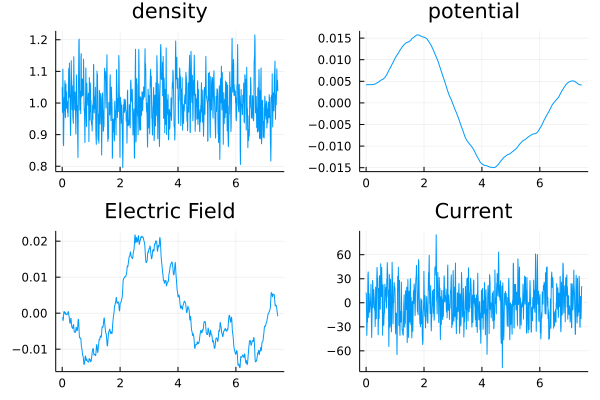

In [9]:
plot(layout=(2,2))
plot!(subplot=1,x,n/n0, title = "density", legend = :false)
plot!(subplot=2,x,ϕ, title = "potential", legend = :false)
plot!(subplot=3,x,E, title = "Electric Field", legend = :false)
plot!(subplot=4,x,S, title = "Current", legend = :false)

Check the histograms for the initial positions and velocities.

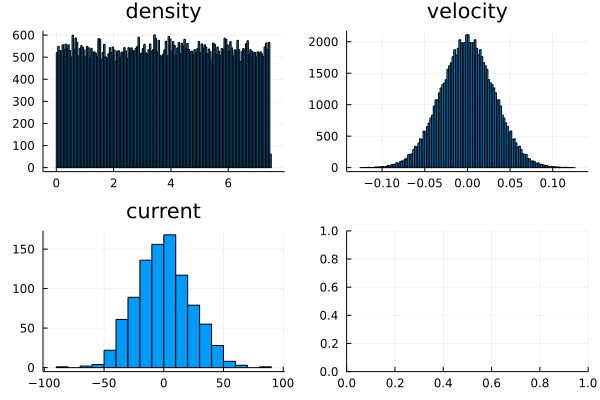

In [10]:
plot(layout=(2,2))
histogram!(subplot=1,u[1:N], title = "density", legend = :false, bins = 300)
histogram!(subplot=2,u[N+1:2*N], title = "velocity", legend = :false)

histogram!(subplot=3,S, title = "current", legend = :false)

In [11]:
if phase_space_show
Plots.scatter(u[1:N],u[N+1:2N]
, thickness_scaling = 0.3
, markersize = 0.3
, title = "phase-space", legend =:false)
png(run_name * "initial-phase-space")
end

## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [12]:
if nthreads() > 1
TS = zeros(J, nthreads())
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current_rel_threads!, Interpolate_2, TS) ;
else
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current_rel!, Interpolate_2) ;
end

if outputs  
    Energy_K = zeros(M_g)
    Energy_E = zeros(M_g)
    E_T = zeros(M_g)
    v_T = zeros(M_g)
    D_T = zeros(M_g)
    S_T = zeros(M_g)
    T = zeros(M_g)
    if animation
    par = zeros(M_g,2N)
    end
    Energy_K[1], Energy_E[1]  = get_energy(u,(L, N, J))
    E_T[1] = sum(u[2N+1:end])
    v_T[1] = sum(u[N+1:2N])
    get_density!(u, n, p)
    get_current!(u, S, p)
    D_T[1] = sum(n)/n0/J - 1
    S_T[1] = sum(S)/n0/J
    T[1] = var(u[N+1:2N])
    if animation
    par[1,:] = u[1:2N]
    end
end





In [13]:
t = 0.0
j = 1

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => pars_f)
if outputs
    run_data = Dict()
    run["Energy_E_$j"] = Energy_E[j]
    run["Energy_K_$j"] = Energy_K[j]
    run["E_f$j"] = u[Nx*Np+1:end]
    run["n_F$j"] = ρ
    run["S_F$j"] = S
    run["E_T$j"] = EField_T[j] 
    run["S_T$j"] = S_T[j]
    run["n_T$j"] = n_T[j]
end


file_name = "Results/"* run_name * ".jld2"
#rm(file_name)

tiempo = @sprintf("%05d", j)
field_name = "u"

save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

jldopen(file_name, "a+") do file
    file[field_name * "/u_$(tiempo)"] = u;
end


160930-element Vector{Float64}:
  2.5227961551354587
  5.073621357495999
  5.576799194262141
  3.821248462404551
  2.6410451121246945
  2.8065064603299046
  5.905246745691921
  5.316684146726895
  2.1695203861330166
  0.792830834456935
  ⋮
  0.002211255588604554
  0.0021272805316901945
  0.00204875188839966
  0.0016967542712366089
  0.001028424913497582
  0.00041180829322730946
  8.391269127049693e-6
 -0.0004274815998889918
 -0.0008571395897000512

In [14]:

for k in 2:M
  RK4_Step!(RHSC_rel,u,t,dt,p_RHSC)
  global u = [make_periodic!(u[1:N],L); u[N+1:end]]
  #filter_constant!(u[2N+1:end])
  global t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    local j = (k-1)÷(M÷(M_g-1))+1
    #scatter(plt, u[1:N], u[N+1:2*N])
    if outputs
      Energy_K[j], Energy_E[j] = get_energy_rel(u,(L, N, J))
      E_T[j] = sum(u[2N+1:end])
      v_T[j] = sum(u[N+1:2N])
      get_density!(u, n, p)
      get_current_rel!(u, S, p)
      D_T[j] = sum(n)/n0/J - 1
      S_T[j] = sum(S)/n0/J
      T[j] = var(u[N+1:2N])
    end

    local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
        end

    Energy_K, Energy_E = get_energy_rel(u,(L, N, J))
    println("j = $j , t = $t, k = $k, nthreads = $(nthreads()), Energy = $(Energy_K + Energy_E)")

    if animation
    par[j,:] = u[1:2N]
    end
  end
end

j = 2 , t = 0.24999999999999997, k = 11, nthreads = 2, Energy = 43.94014156523095
j = 3 , t = 0.5000000000000001, k = 21, nthreads = 2, Energy = 43.93898222922311
j = 4 , t = 0.7500000000000003, k = 31, nthreads = 2, Energy = 43.9373407203889
j = 5 , t = 1.0000000000000004, k = 41, nthreads = 2, Energy = 43.935727504551295
j = 6 , t = 1.2499999999999996, k = 51, nthreads = 2, Energy = 43.93441650303138
j = 7 , t = 1.4999999999999987, k = 61, nthreads = 2, Energy = 43.93376095831786
j = 8 , t = 1.7499999999999978, k = 71, nthreads = 2, Energy = 43.933889816081134
j = 9 , t = 1.999999999999997, k = 81, nthreads = 2, Energy = 43.93487606906654
j = 10 , t = 2.249999999999996, k = 91, nthreads = 2, Energy = 43.93643499375865
j = 11 , t = 2.499999999999995, k = 101, nthreads = 2, Energy = 43.93780742828033
j = 12 , t = 2.7499999999999942, k = 111, nthreads = 2, Energy = 43.93900561393599
j = 13 , t = 2.9999999999999933, k = 121, nthreads = 2, Energy = 43.93973190390025
j = 14 , t = 3.2499999

j = 126 , t = 31.249999999999293, k = 1251, nthreads = 2, Energy = 43.93949130820417
j = 127 , t = 31.49999999999928, k = 1261, nthreads = 2, Energy = 43.939329081158625
j = 128 , t = 31.749999999999265, k = 1271, nthreads = 2, Energy = 43.938411638668754
j = 129 , t = 31.99999999999925, k = 1281, nthreads = 2, Energy = 43.93704883763419
j = 130 , t = 32.24999999999924, k = 1291, nthreads = 2, Energy = 43.93557190545608
j = 131 , t = 32.499999999999226, k = 1301, nthreads = 2, Energy = 43.93438226403352
j = 132 , t = 32.74999999999921, k = 1311, nthreads = 2, Energy = 43.933666618676405
j = 133 , t = 32.9999999999992, k = 1321, nthreads = 2, Energy = 43.93374259498281
j = 134 , t = 33.24999999999918, k = 1331, nthreads = 2, Energy = 43.93446287766533
j = 135 , t = 33.49999999999917, k = 1341, nthreads = 2, Energy = 43.93569127204656
j = 136 , t = 33.749999999999154, k = 1351, nthreads = 2, Energy = 43.93722702212606
j = 137 , t = 33.99999999999914, k = 1361, nthreads = 2, Energy = 43.9

Saving the results

In [ ]:
#=
n_F = zeros(J)
S_F = zeros(J)
get_density!(u, n_F, p)
get_current!(u, S_F, p)
run = Dict("run_name" => run_name, "p" => p, "Energy_E" => Energy_E, "Energy_K" => Energy_K, "E_f" => u[2N+1:end], "n_F" => n_F, "S_F" => S_F, "E_T"=> E_T, "v_T" => v_T, "S_T" => S_T, "D_T" => D_T, "T" => T)
save(run_name * "th$(nthreads())_results.jld2", run)
=#

## Studying the solutions: 

Post procesing is done in post_pro_landau_rel

### Energy:

In [ ]:
plot(abs.(Energy_K[2:end] .- Energy_K[1]), title = "Energy conservation", label = "Kinetic Energy"
#, legend = :outertopright
, legend = :bottomright)
plot!(abs.(Energy_E[2:end] .- Energy_E[1]), label = "|Electric Energy|")
plot!(abs.(Energy_K[2:end]  + Energy_E[2:end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1]+Energy_E[1]) , yscale=:log10
#, xscale=:log10
, label = "Total Energy / Initial Energy -1 ")
#png(run_name * "energy_conservation")

In [ ]:
abs.(Energy_K[end]  + Energy_E[end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1]+Energy_E[1])

In [ ]:
#ω = 1
#tv = [dt*(i-1) for i in 1:M]
plot(T, label= "θ", title = "Temperature = var", legend = false)
#plot!(sin.(ω*tv))
#png(run_name * "temperature")

34 peaks in T = 100, so $\omega = 0.34$

In [ ]:
Th = rfft(T)
plot(real.(Th))
argmin(real.(Th))*t_f/length(T) * sqrt(θ)
#length(T)

In [ ]:
T[end]

We save the data:

| time | order | energy | theta |
|------|-------|--------|-------|
|  40  |  1    | 7.4e-7 | 0.009978|
|  40  |  3    | 7.9e-8 | 0.009979 |
|  40  |  5    | 1.1e-7 | 0.009979 |
|  4000|  1    | 7.6e-5 | 0.009978 |
|  4000|  3    | 7.2e-6 | 0.010086 |
|  4000|  5    | 1.0e-5 | 0.010031 |
|  4e6 |  1    | 0.0360 | 0.010119 |


## Total Quantities

In [ ]:
plot(layout=(2,2))
plot!(subplot=1,E_T,title="Total Electric Field")
plot!(subplot=2,v_T./N, title="Total velocity")
plot!(subplot=3,D_T,title = "Total density")
plot!(subplot=4,S_T,title = "Total Current")
#png(run_name * "totals")

In [ ]:
E_F = zeros(J)
ϕ_F = zeros(J)
n_F = zeros(J)
get_density!(u, n_F, p)
n0 = N/L
get_ϕ!(ϕ_F, n_F/n0 .+ 1, κ)
#get_ϕ!(ϕ_F, n_F .- n0, κ)
get_E_from_ϕ!(ϕ_F,E_F,dx)
plot(x,u[2N+1:end], label = "dynamical", title="Electric Field with order = $(order)")
plot!(x,E_F,label="from constraint", ls=:dash)
#t_f = 40
#png(run_name * "E")

In [ ]:
println("averaged total E field = $(sum(E_F))")
println("E_total = $(sum(u[2N+1:end])/J)")
println("Total velocity = $(sum(u[N+1:2N])/N)")
println("Total Charge = $(sum(n_F .- n0))")
println("Final Energy = $(get_energy(u,(L, N, J)))")
get_current!(u, S, p)
println("Total_current = $(sum(S)/J)")

In [ ]:
plot(x,u[2N+1:end]-E_F, label = "difference", title="Electric Field")
#png(run_name * "electric_diff")

In [ ]:
if phase_space_show
Plots.scatter(u[1:N],u[N+1:2N]
#, thickness_scaling = 0.3
, markersize = 0.3
, title = "phase-space", legend =:false)
#png(run_name * "ps")
end

In [ ]:
if animation
    anim = @animate for i = 1:M_g
        Plots.scatter(par[i,1:N], par[i,N+1:2N]
        , markersize = 0.3
        , title = "phase-space"
        , legend=false
        , ylim = (-0.3,0.3)
        , xlim = (0,5)
        )
    end
 
    gif(anim, run_name * "ps_fps5.gif", fps = 5)
end

In [ ]:
#load("Results/" * run_name * "results.jld2", "S_F")

In [ ]:
#(p, Energy_E, Energy_K, E_f, n_F, S_F, E_T, v_T, S_T, D_T, T) = load("Results/" * run_name * "results.jld2", "p", "Energy_E", "Energy_K", "E_f", "n_F",  "S_F", "E_T", "v_T", "S_T", "D_T", "T");


In [ ]:
using LsqFit